### Imports

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf

# Int cufflinks
#making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

### 01. Load the Dataset

In [63]:
from sklearn.datasets import load_iris
data = load_iris()

### 02. Explorethe Dataset

In [64]:
# Explore the dataset
data.data.shape

(150, 4)

In [65]:
print(f'Classes to predict: {data.target_names}')
print(f'Features: {data.feature_names}')

Classes to predict: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [66]:
#Plotting data
def plot_data(dataset):
    """Plot out all the data from the dataset in different histograms"""
    dataset.hist(bins=50, figsize = (20,15))
    plt.show()
    return


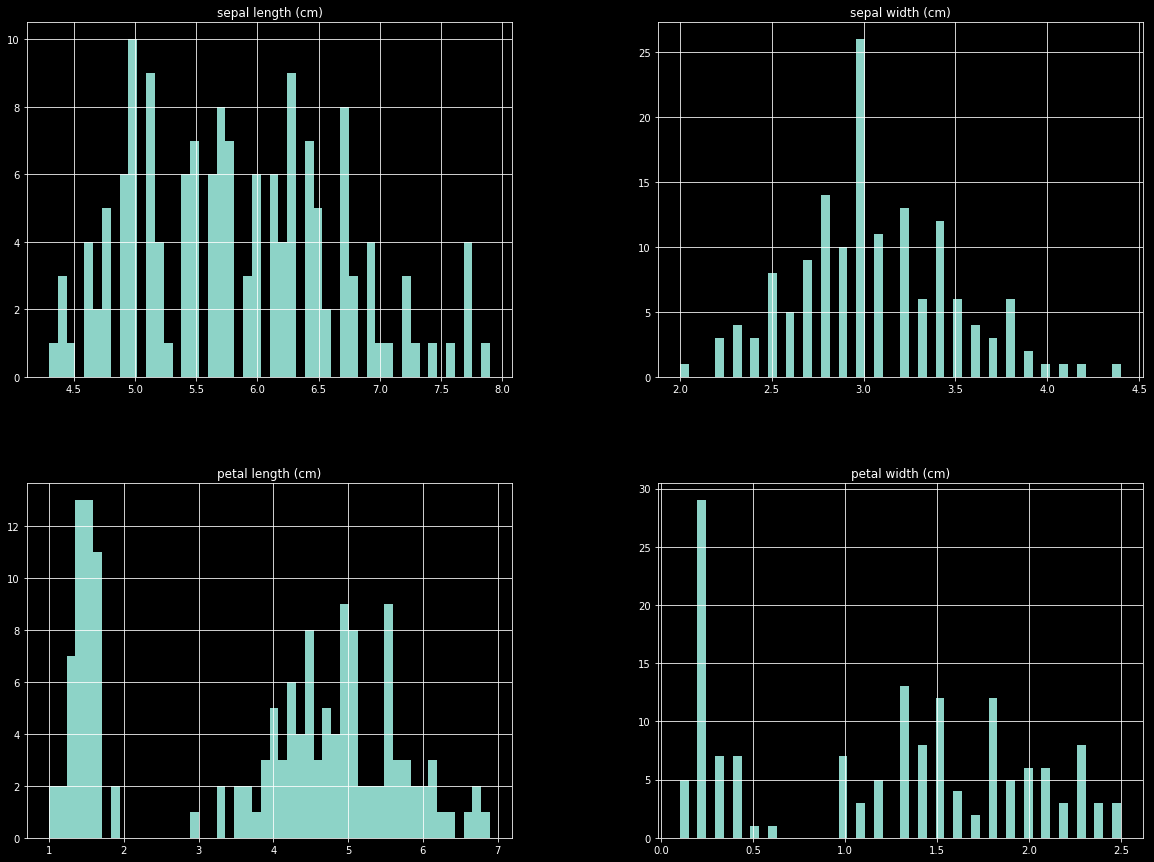

In [67]:
dataset = pd.DataFrame(data.data, columns=data.feature_names)
plot_data(dataset)

### 03. Correlation Matrix

<AxesSubplot:>

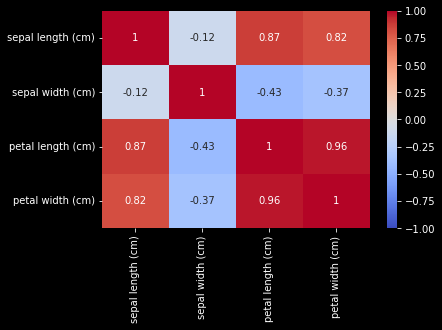

In [68]:
# Correlation data
corr = dataset.corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

Meaningful correlation found between:
 - petal width & petal length (very high correlation)
 - petal width & sepal length (high correlation)


### Functions for Checking Parameters

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve

# Check AOC ARC curve
def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc = roc_auc_score(labels_test, pred, multi_class='ovr')
    print('AUROC score: {:.2f}'.format(auc))

    false_positive_rate, true_positive_rate, thresolds = roc_curve(labels_test, pred)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'y')

    plt.plot([0,1],[0,1], linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightyellow', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    return auc

In [70]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred, average='weighted')

    # Check recall
    recall = recall_score(labels_test , pred, average='weighted')

    # Check F1 score
    F1 = f1_score( labels_test , pred, average='weighted')

    print('Accuracy: {}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(F1))

    auc = 'NA'
    #auc = aoc_arc_curve(pred, labels_test)

    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':F1, 'auc': auc}


### 04 Data Pre-processing

In [71]:
from sklearn.model_selection import train_test_split

# Create features and labels
features = data.data
labels = data.target

# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.25)

### 04.1 Scaling

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

### 04.2 Imputation

In [73]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(features_train_scaled)
features_train_imputated = imputer.transform(features_train_scaled)

imputer = imputer.fit(features_test_scaled)
features_test_imputated = imputer.transform(features_test_scaled)


### 04.3 Imablanced Data

#### Up-sampling  _(with `imblearn`)_

In [74]:
from imblearn.over_sampling import SMOTE

# Re-sizing the data
features_train_balanced, labels_train_balanced = SMOTE().fit_resample(features_train_imputated, labels_train)
features_test_balanced, labels_test_balanced = SMOTE().fit_resample(features_test_imputated, labels_test)


#### Down-sampling  _(with `imblearn`)_

In [75]:
from imblearn.under_sampling import RandomUnderSampler

# Re-sizing the data
rus = RandomUnderSampler(random_state=42)
features_train_balanced2, labels_train_balanced2 = rus.fit_resample(features_train_imputated, labels_train)
features_test_balanced2, labels_test_balanced2 = rus.fit_resample(features_test_imputated, labels_test)

## Pipeline Methods

In [76]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def evaluate(pred, labels_test):
    """Evaluate the results of the Random Forest classifier"""
    conf_matrix = confusion_matrix(labels_test,pred)
    print(f'Confusion matrix:\n\n{pd.DataFrame(conf_matrix)}\n')
    classif_report = classification_report(labels_test,pred)
    print(f'Classfication Report:\n\n{classif_report}\n')
    accuracy = accuracy_score(labels_test,pred)
    print(f'Accuracy Score:\n{accuracy}\n')

    return {'accuracy': accuracy}

In [77]:
def run_classifier(classifier, features_train, labels_train, features_test, labels_test) -> dict:
    # Fit data for training into classifier
    classifier.fit(features_train , labels_train)
    # Predicting with classifier
    pred = classifier.predict(features_test)
    return evaluate(pred,labels_test)


In [281]:
def compare_parameters(classifier):
    """Parameter Comparison"""
    raw_param = run_classifier(classifier, features_train, labels_train, features_test, labels_test)
    scaled_param = run_classifier(classifier, features_train_scaled, labels_train, features_test_scaled, labels_test)
    imputed_param = run_classifier(classifier, features_train_imputated, labels_train, features_test_imputated, labels_test)
    upsamp_param = run_classifier(classifier, features_train_balanced, labels_train_balanced, features_test_balanced, labels_test_balanced)
    downsamp_param = run_classifier(classifier, features_train_balanced2, labels_train_balanced2, features_test_balanced2, labels_test_balanced2)

    # Plot out different parameters
    compare = [raw_param, scaled_param, imputed_param, downsamp_param, upsamp_param]
    headers_comparison = ['Raw', 'Scaled', 'Imputed', 'Down-sampling (Imblearn)', 'Up-sampling (Imblearn)']

    # Create dataframe for parameter comparison
    compare_df = pd.DataFrame(compare)
    compare_df["results"]=headers_comparison
    compare_df = compare_df.set_index('results', drop=True).rename_axis(None)

    # Plot
    compare_df.iplot(kind='bar', width=0.9)

#### Run Algorithm

In [282]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(criterion='entropy', n_estimators=50, verbose=0, n_jobs=-1)
compare_parameters(classifier)



Confusion matrix:

    0  1   2
0  18  0   0
1   0  6   2
2   0  0  12

Classfication Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.75      0.86         8
           2       0.86      1.00      0.92        12

    accuracy                           0.95        38
   macro avg       0.95      0.92      0.93        38
weighted avg       0.95      0.95      0.95        38


Accuracy Score:
0.9473684210526315

Confusion matrix:

    0  1   2
0  18  0   0
1   0  6   2
2   0  0  12

Classfication Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.75      0.86         8
           2       0.86      1.00      0.92        12

    accuracy                           0.95        38
   macro avg       0.95      0.92      0.93        38
weighted avg       0.95      0.95      0.95        38


Accuracy S